# 🧠 Parkinson’s Telemonitoring – EDA y Modelos Predictivos  
### Proyecto de Regresión – Machine Learning  
**Autor:** 
**Fecha:** 2025  

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("coolwarm")

In [10]:
df = pd.read_csv("../data/parkinsons_updrs.csv")
df.head()

subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0         1   72    0     5.6431       28.199       34.398    0.00662   
1         1   72    0    12.6660       28.447       34.894    0.00300   
2         1   72    0    19.6810       28.695       35.389    0.00481   
3         1   72    0    25.6470       28.905       35.810    0.00528   
4         1   72    0    33.6420       29.187       36.375    0.00335   

   Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer(dB)  Shimmer:APQ3  \
0     0.000034     0.00401      0.00317  ...        0.230       0.01438   
1     0.000017     0.00132      0.00150  ...        0.179       0.00994   
2     0.000025     0.00205      0.00208  ...        0.181       0.00734   
3     0.000027     0.00191      0.00264  ...        0.327       0.01106   
4     0.000020     0.00093      0.00130  ...        0.176       0.00679   

   Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE  \
0       0.01309        0.01662      0.04314  0.014290  21.640  0.41888   
1       0.01072        0.01689      0.02982  0.011112  27.183  0.43493   
2       0.00844        0.01458      0.02202  0.020220  23.047  0.46222   
3       0.01265        0.01963      0.03317  0.027837  24.445  0.48730   
4       0.00929        0.01819      0.02036  0.011625  26.126  0.47188   

       DFA      PPE  
0  0.54842  0.16006  
1  0.56477  0.10810  
2  0.54405  0.21014  
3  0.57794  0.33277  
4  0.56122  0.19361  

[5 rows x 22 columns]

In [11]:
df = df.rename(columns={'subject#': 'subject_id'})

In [12]:
df.info()
df.describe().T
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject_id     5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

np.int64(0)

In [13]:
df = df.drop_duplicates()
df = df.dropna()

df['test_time'] = pd.to_numeric(df['test_time'], errors='coerce')
df = df[df['test_time'] >= 0]
df.reset_index(drop=True, inplace=True)

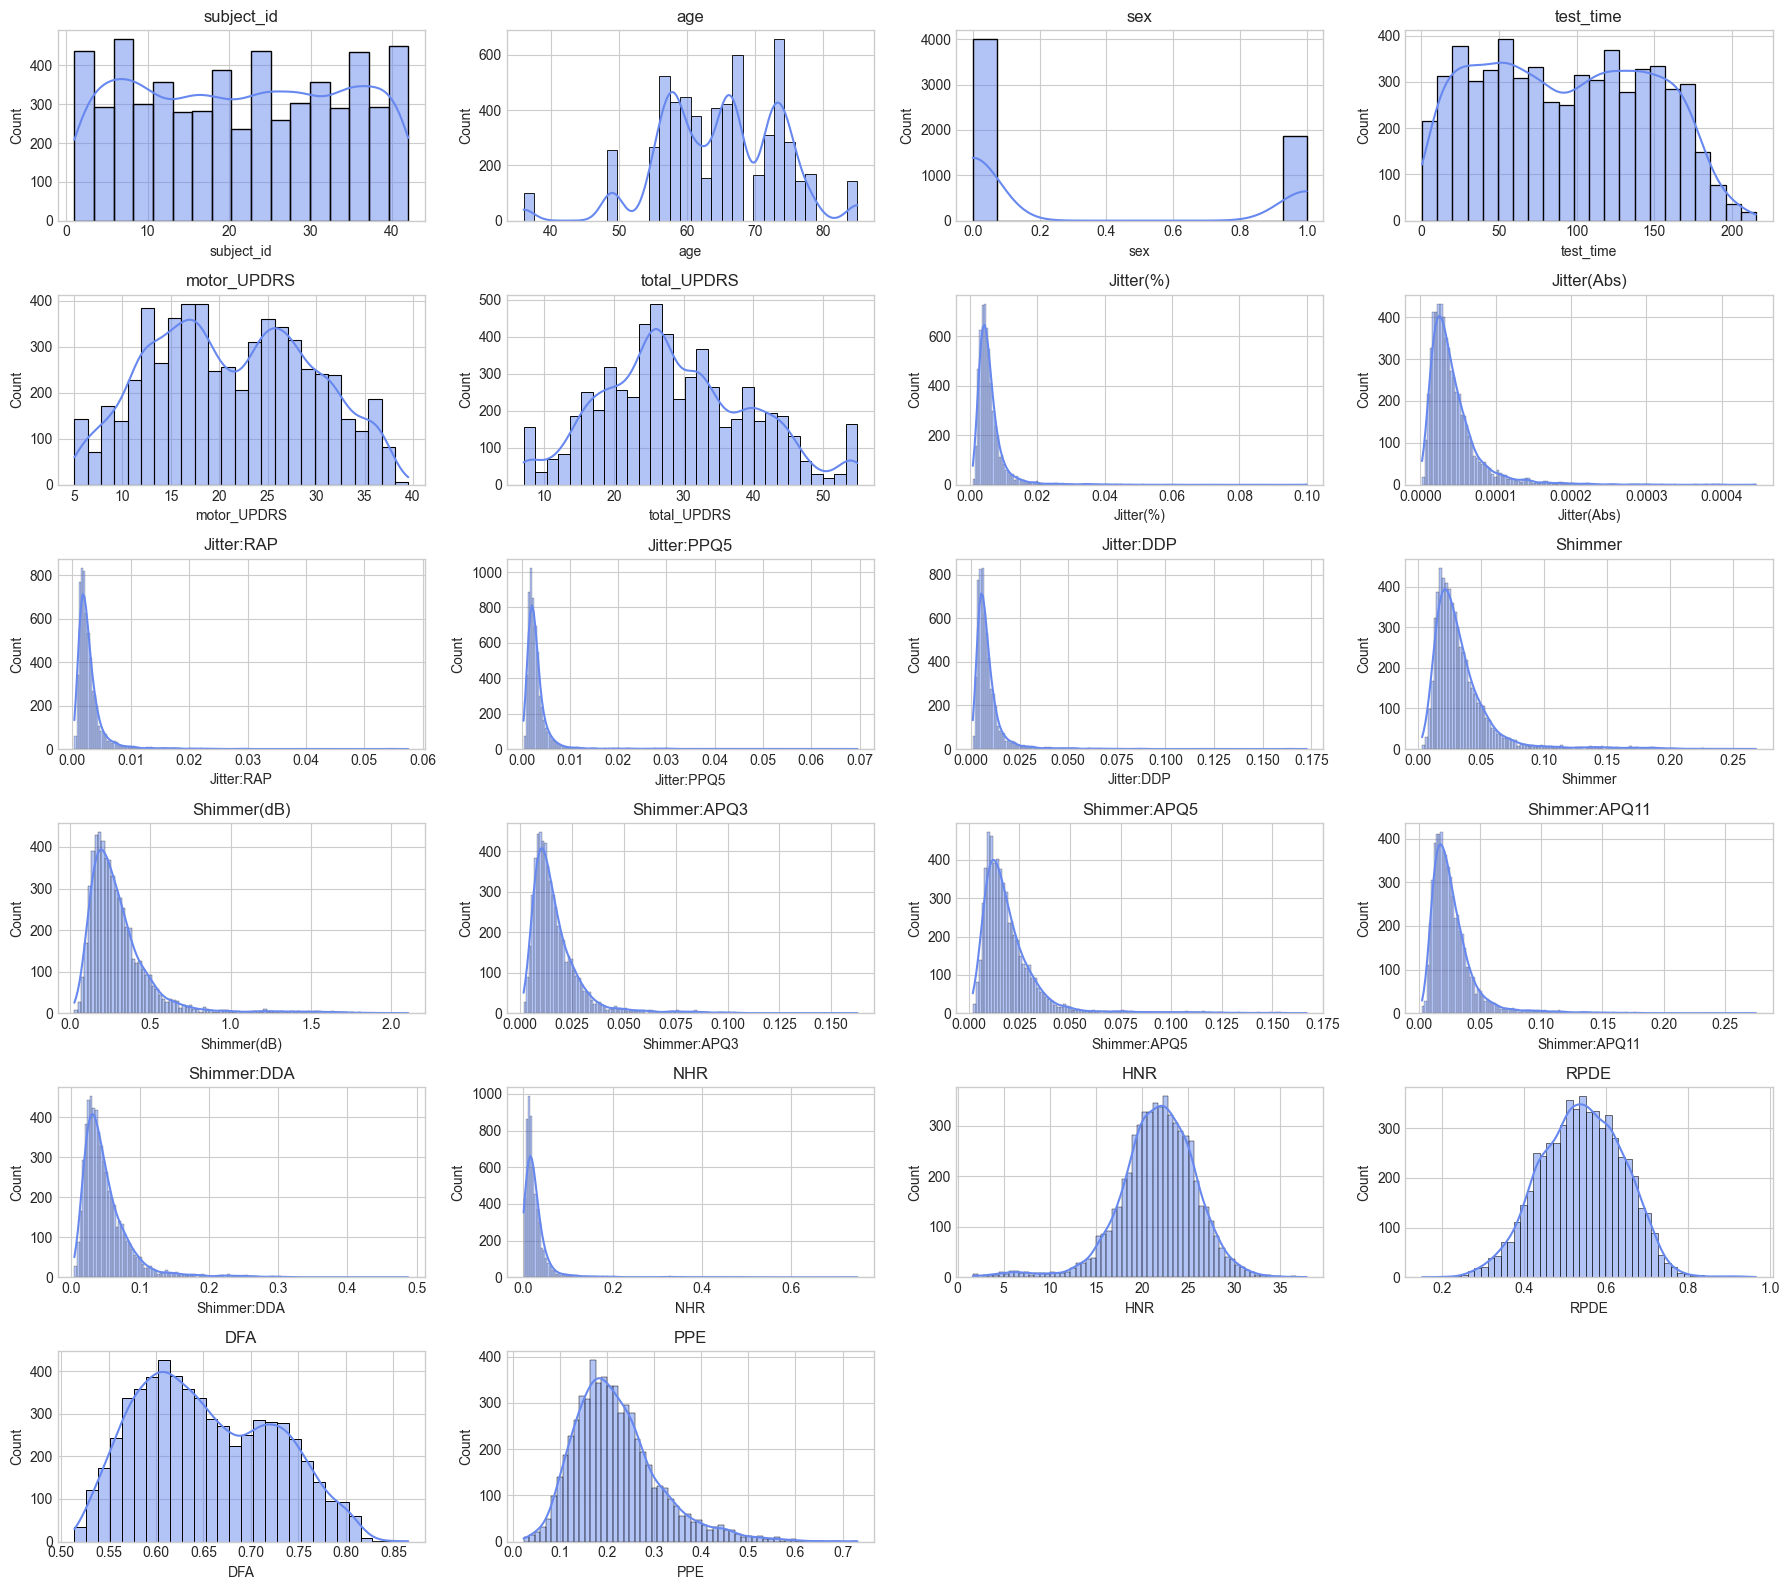

In [14]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(18, 16))
for i, col in enumerate(num_cols, 1):
    plt.subplot(6, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

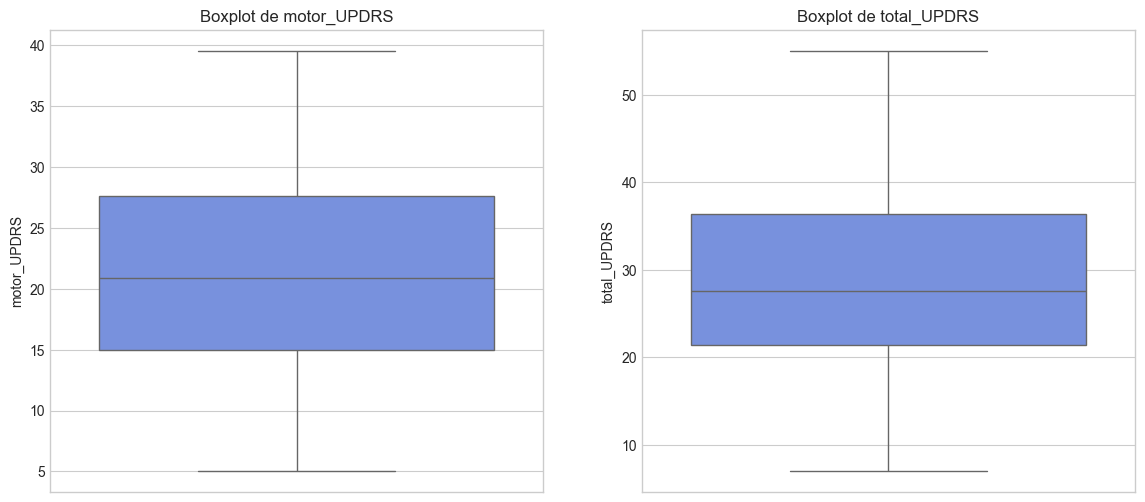

Outliers en motor_UPDRS: 0
Outliers en total_UPDRS: 0


In [15]:
cols_box = ['motor_UPDRS', 'total_UPDRS']

plt.figure(figsize=(14,6))
for i, col in enumerate(cols_box, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
plt.show()

for col in cols_box:
    z = zscore(df[col])
    print(f"Outliers en {col}: {(np.abs(z)>3).sum()}")

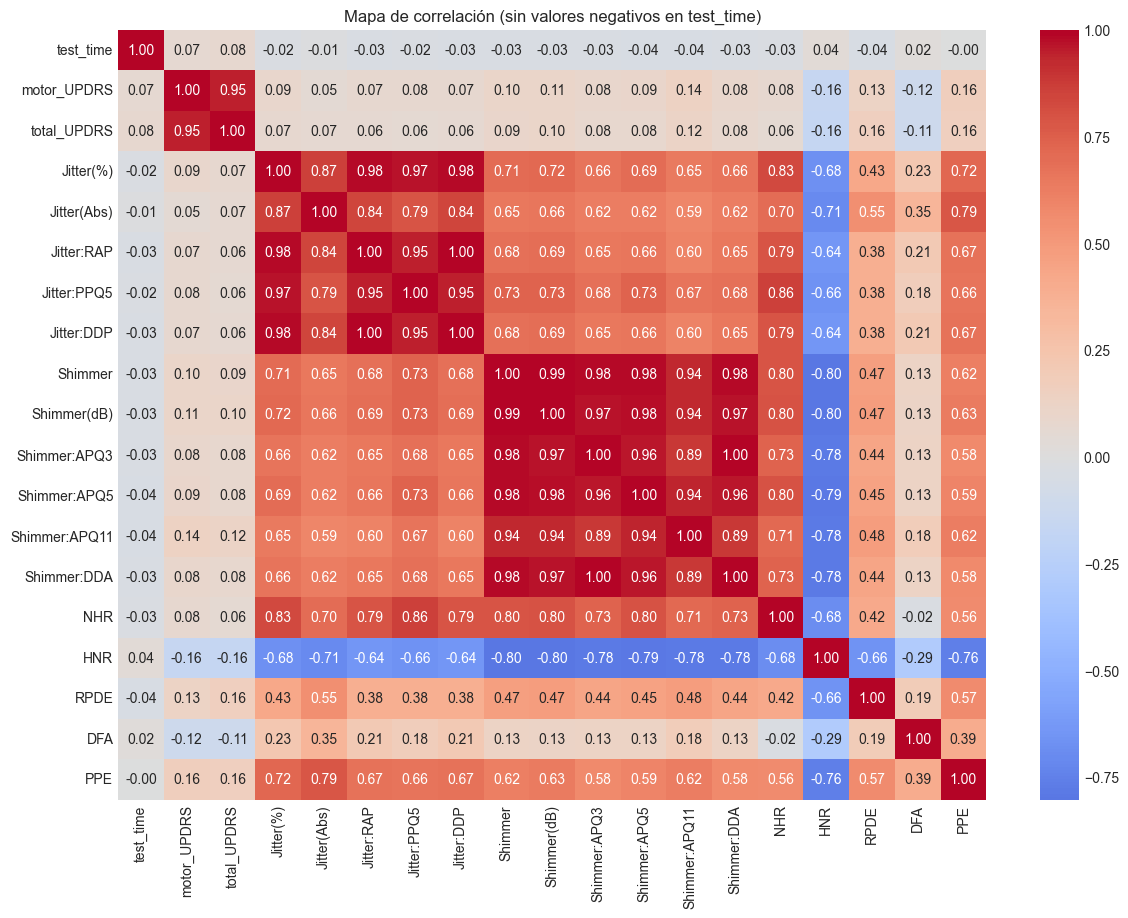

In [17]:
plt.figure(figsize=(14, 10))

corr_matrix = df.drop(['subject_id', 'sex', 'age'], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de correlación (sin valores negativos en test_time)")
plt.show()

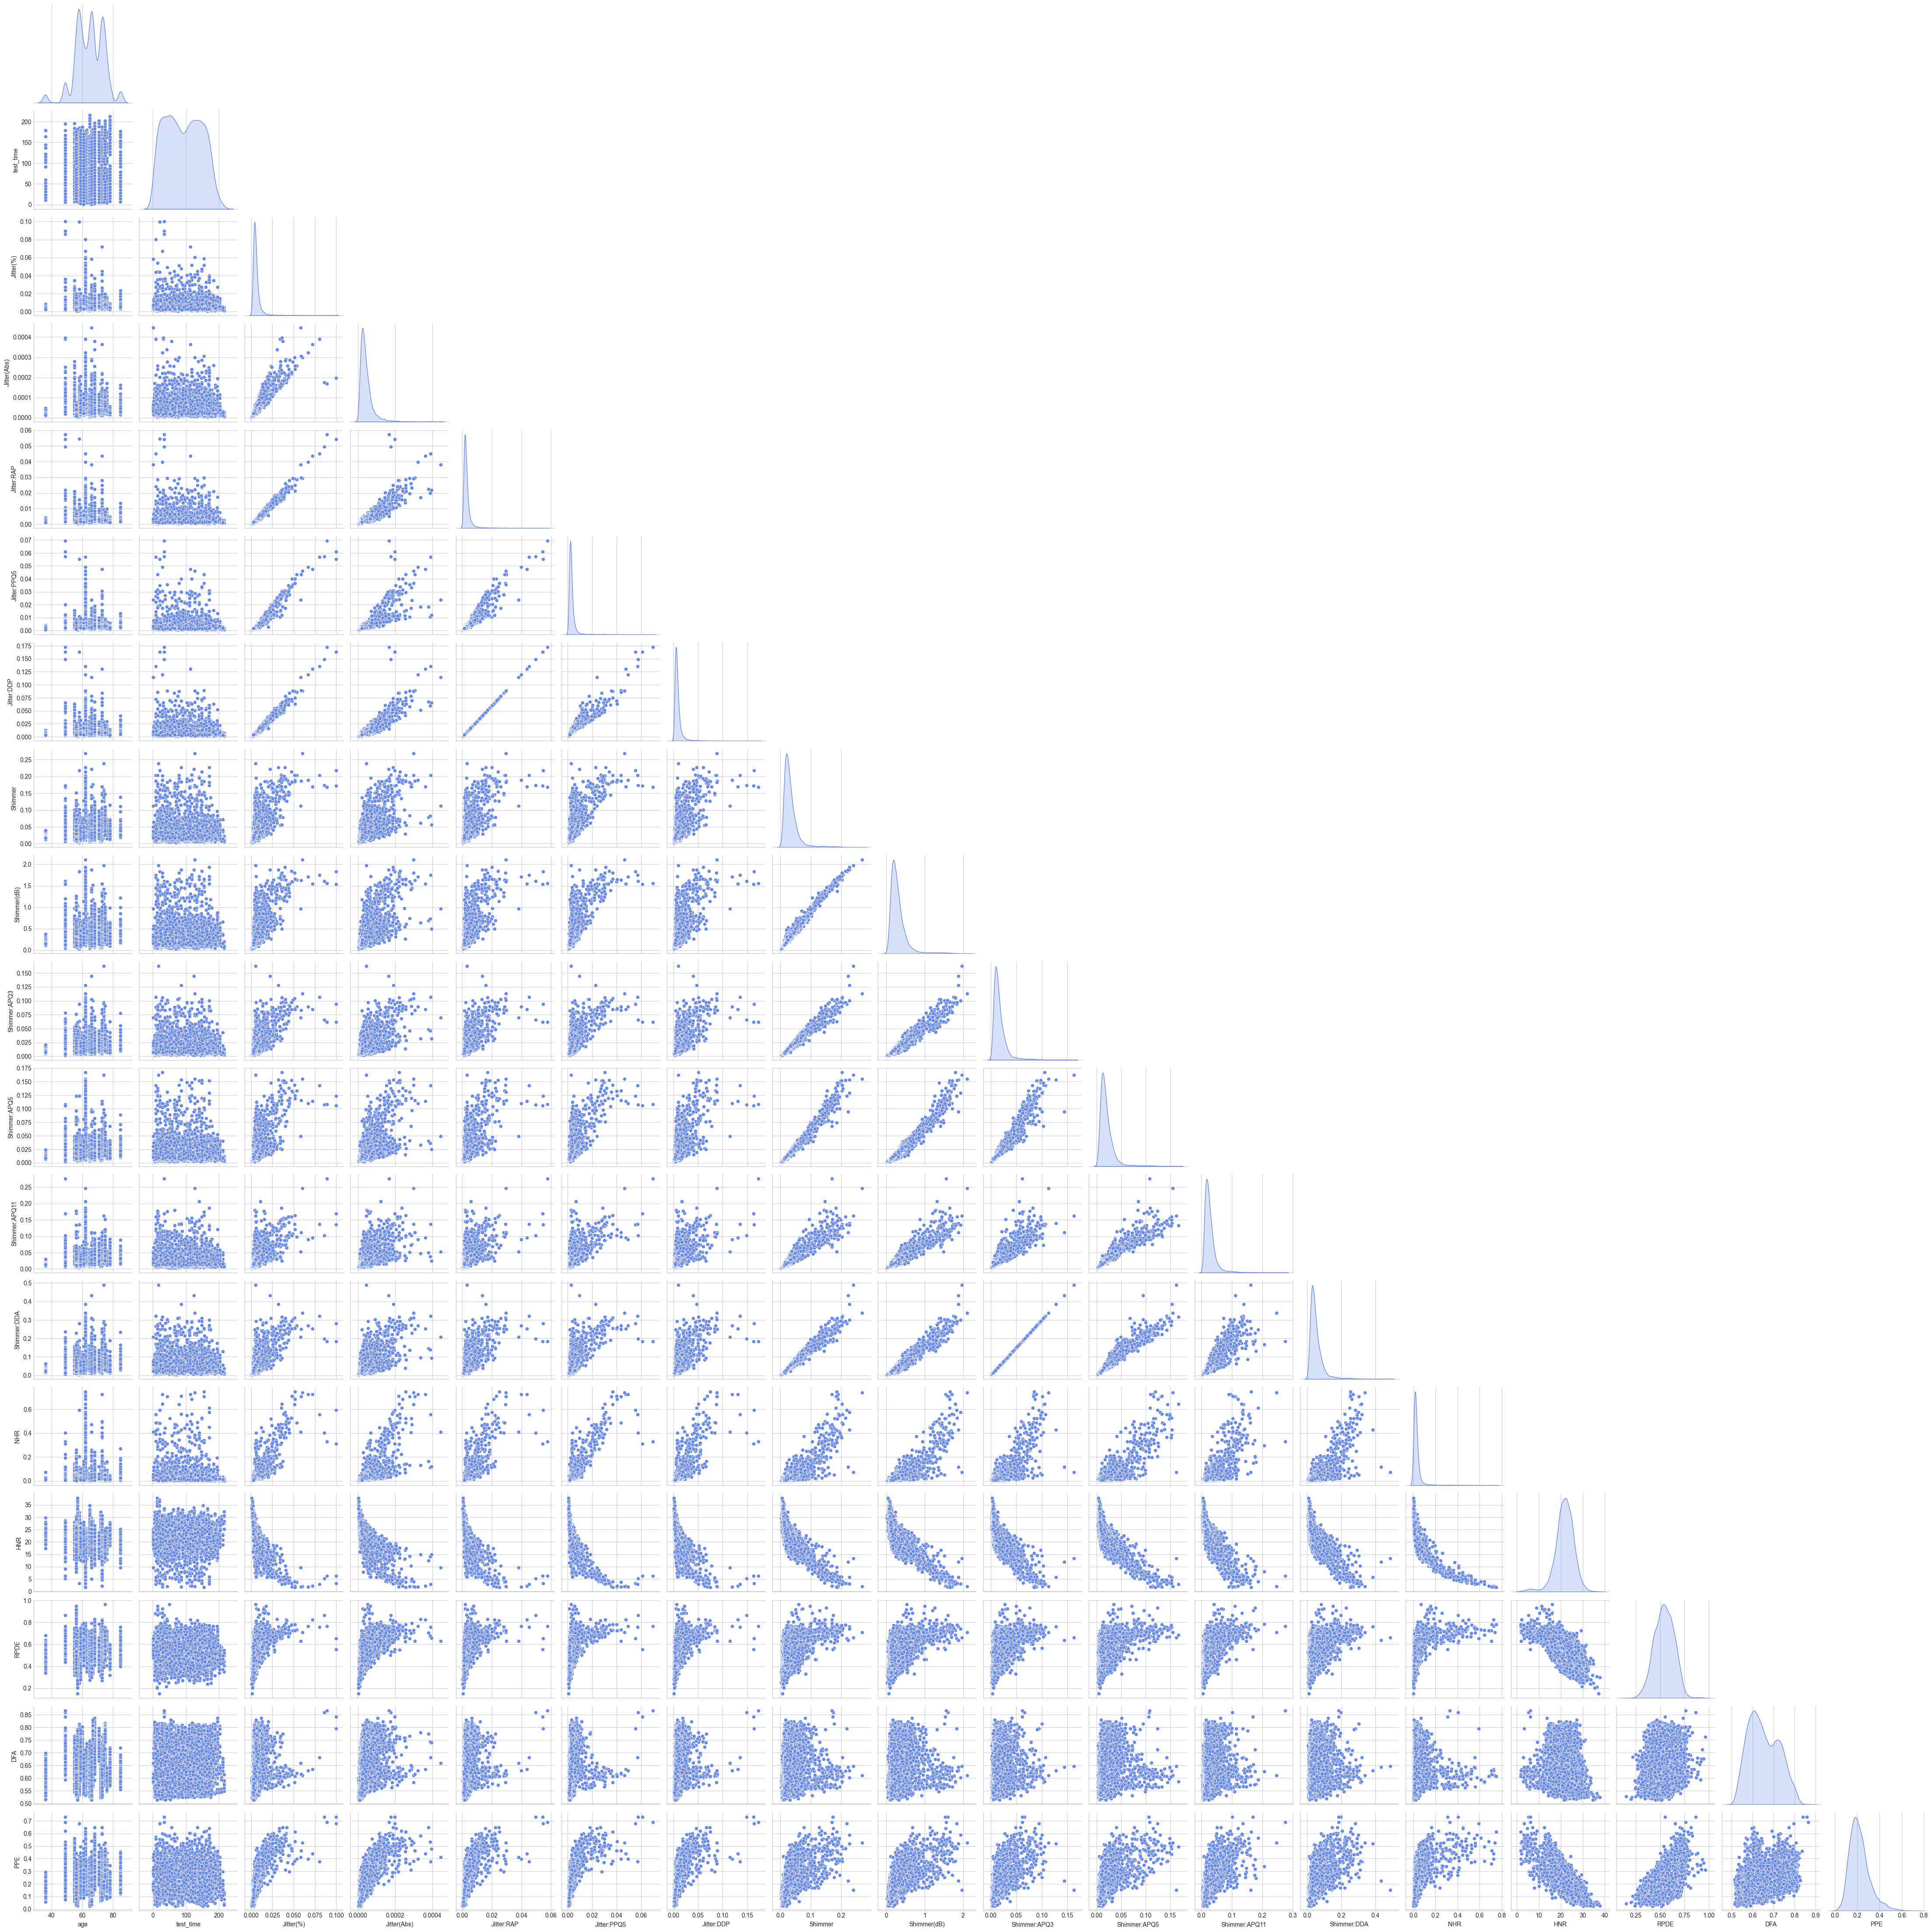

In [18]:
vars_acusticas = df.drop(['subject_id','sex','motor_UPDRS','total_UPDRS'], axis=1)
sns.pairplot(vars_acusticas, diag_kind='kde', corner=True)
plt.show()

In [19]:
desc = df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
desc['skew'] = df[num_cols].skew()
desc['kurtosis'] = df[num_cols].kurtosis()
desc

count       mean        std        min        25%        50%  \
subject_id     5863.0  21.460345  12.361029   1.000000  10.000000  22.000000   
age            5863.0  64.814771   8.827750  36.000000  58.000000  65.000000   
sex            5863.0   0.318438   0.465910   0.000000   0.000000   0.000000   
test_time      5863.0  93.061538  53.320896   0.395830  47.335500  91.754000   
motor_UPDRS    5863.0  21.289655   8.133419   5.037700  15.000000  20.871000   
total_UPDRS    5863.0  29.014090  10.709966   7.000000  21.362000  27.522000   
Jitter(%)      5863.0   0.006156   0.005628   0.000830   0.003580   0.004900   
Jitter(Abs)    5863.0   0.000044   0.000036   0.000002   0.000022   0.000035   
Jitter:RAP     5863.0   0.002988   0.003126   0.000330   0.001580   0.002250   
Jitter:PPQ5    5863.0   0.003278   0.003734   0.000430   0.001825   0.002490   
Jitter:DDP     5863.0   0.008965   0.009378   0.000980   0.004730   0.006750   
Shimmer        5863.0   0.034038   0.025836   0.003060   0.019110   0.027530   
Shimmer(dB)    5863.0   0.311012   0.230310   0.026000   0.175000   0.253000   
Shimmer:APQ3   5863.0   0.017157   0.013237   0.001610   0.009280   0.013700   
Shimmer:APQ5   5863.0   0.020149   0.016672   0.001940   0.010790   0.015940   
Shimmer:APQ11  5863.0   0.027489   0.020002   0.002490   0.015660   0.022710   
Shimmer:DDA    5863.0   0.051470   0.039710   0.004840   0.027830   0.041110   
NHR            5863.0   0.032126   0.059735   0.000286   0.010953   0.018448   
HNR            5863.0  21.679527   4.292521   1.659000  19.404000  21.917000   
RPDE           5863.0   0.541423   0.101024   0.151020   0.469695   0.542250   
DFA            5863.0   0.653252   0.070955   0.514040   0.596100   0.643550   
PPE            5863.0   0.219618   0.091494   0.021983   0.156385   0.205560   

                      75%         max      skew   kurtosis  
subject_id      33.000000   42.000000  0.005478  -1.248305  
age             72.000000   85.000000 -0.382077   0.669076  
sex              1.000000    1.000000  0.779654  -1.392615  
test_time      138.460000  215.490000  0.079490  -1.149525  
motor_UPDRS     27.594000   39.511000  0.076748  -0.938216  
total_UPDRS     36.400500   54.992000  0.272120  -0.359421  
Jitter(%)        0.006800    0.099990  6.450972  67.448653  
Jitter(Abs)      0.000053    0.000446  3.283195  18.151715  
Jitter:RAP       0.003290    0.057540  6.943769  78.465296  
Jitter:PPQ5      0.003470    0.069560  7.582627  81.463668  
Jitter:DDP       0.009880    0.172630  6.943706  78.463167  
Shimmer          0.039775    0.268630  3.314150  15.258467  
Shimmer(dB)      0.365000    2.107000  3.099874  13.097558  
Shimmer:APQ3     0.020605    0.162670  3.098401  14.744581  
Shimmer:APQ5     0.023775    0.167020  3.698075  19.238243  
Shimmer:APQ11    0.032725    0.275460  3.404656  19.129624  
Shimmer:DDA      0.061805    0.488020  3.098403  14.744626  
NHR              0.031464    0.748260  6.547359  52.556493  
HNR             24.445500   37.875000 -0.810924   2.503958  
RPDE             0.614045    0.966080 -0.037453  -0.065996  
DFA              0.711480    0.865600  0.281782  -0.882864  
PPE              0.264590    0.731730  1.088670   1.948892

In [20]:
df.corr(method='pearson')
df.corr(method='spearman')

subject_id       age       sex  test_time  motor_UPDRS  \
subject_id       1.000000 -0.008333  0.288606   0.004798     0.241836   
age             -0.008333  1.000000 -0.041164   0.009715     0.303686   
sex              0.288606 -0.041164  1.000000  -0.006936    -0.038057   
test_time        0.004798  0.009715 -0.006936   1.000000     0.060648   
motor_UPDRS      0.241836  0.303686 -0.038057   0.060648     1.000000   
total_UPDRS      0.274579  0.319679 -0.068445   0.063634     0.957839   
Jitter(%)        0.148082  0.170216 -0.095280  -0.008173     0.128945   
Jitter(Abs)      0.071771  0.131139 -0.342223  -0.008186     0.073032   
Jitter:RAP       0.144630  0.138416 -0.000693  -0.017420     0.107502   
Jitter:PPQ5      0.133570  0.168582 -0.103377  -0.005357     0.121010   
Jitter:DDP       0.144668  0.138431 -0.000723  -0.017390     0.107552   
Shimmer          0.084746  0.273980 -0.105201  -0.026236     0.136663   
Shimmer(dB)      0.073015  0.276813 -0.111484  -0.021388     0.140701   
Shimmer:APQ3     0.062772  0.241149 -0.073060  -0.019179     0.114107   
Shimmer:APQ5     0.067650  0.261204 -0.111196  -0.023453     0.121735   
Shimmer:APQ11    0.110186  0.300705 -0.152525  -0.030062     0.164124   
Shimmer:DDA      0.062782  0.241143 -0.073056  -0.019176     0.114109   
NHR              0.124240  0.171479 -0.063621  -0.025474     0.136103   
HNR             -0.168931 -0.184353  0.075950   0.033002    -0.158414   
RPDE             0.139805  0.135278 -0.159573  -0.037928     0.117899   
DFA              0.104281 -0.090598 -0.152529   0.018476    -0.131689   
PPE              0.144737  0.183268 -0.168670  -0.005064     0.164297   

               total_UPDRS  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
subject_id        0.274579   0.148082     0.071771    0.144630     0.133570   
age               0.319679   0.170216     0.131139    0.138416     0.168582   
sex              -0.068445  -0.095280    -0.342223   -0.000693    -0.103377   
test_time         0.063634  -0.008173    -0.008186   -0.017420    -0.005357   
motor_UPDRS       0.957839   0.128945     0.073032    0.107502     0.121010   
total_UPDRS       1.000000   0.130015     0.104583    0.109878     0.119082   
Jitter(%)         0.130015   1.000000     0.902048    0.956135     0.959081   
Jitter(Abs)       0.104583   0.902048     1.000000    0.821729     0.886535   
Jitter:RAP        0.109878   0.956135     0.821729    1.000000     0.947983   
Jitter:PPQ5       0.119082   0.959081     0.886535    0.947983     1.000000   
Jitter:DDP        0.109915   0.956145     0.821727    0.999996     0.947997   
Shimmer           0.138002   0.652922     0.625195    0.645260     0.686888   
Shimmer(dB)       0.140432   0.673444     0.634548    0.657712     0.698808   
Shimmer:APQ3      0.120270   0.616317     0.579985    0.632430     0.657368   
Shimmer:APQ5      0.125402   0.622540     0.606618    0.617159     0.667058   
Shimmer:APQ11     0.161536   0.635411     0.634783    0.598575     0.668192   
Shimmer:DDA       0.120273   0.616315     0.579981    0.632428     0.657366   
NHR               0.144369   0.797796     0.745523    0.744975     0.752890   
HNR              -0.162690  -0.756693    -0.756810   -0.726628    -0.790294   
RPDE              0.150022   0.530027     0.634705    0.445855     0.510680   
DFA              -0.141727   0.440974     0.495041    0.430046     0.480240   
PPE               0.156092   0.845165     0.804103    0.772100     0.843625   

               ...  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  Shimmer:APQ11  \
subject_id     ...     0.073015      0.062772      0.067650       0.110186   
age            ...     0.276813      0.241149      0.261204       0.300705   
sex            ...    -0.111484     -0.073060     -0.111196      -0.152525   
test_time      ...    -0.021388     -0.019179     -0.023453      -0.030062   
motor_UPDRS    ...     0.140701      0.114107      0.121735       0.164124   
total_UPDRS    ...     0.140432      0.120270    

In [21]:
X = df.drop(['motor_UPDRS','total_UPDRS','sex','subject_id','age'], axis=1)
y = df['motor_UPDRS']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [22]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01),
    'Elastic Net': ElasticNet(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results[name] = {
        'MSE': mean_squared_error(y_test, pred),
        'R2': r2_score(y_test, pred)
    }

pd.DataFrame(results).T

MSE        R2
Linear Regression  57.888486  0.118259
Ridge              57.926970  0.117673
Lasso              58.088402  0.115214
Elastic Net        58.889022  0.103019
Decision Tree      58.535680  0.108401
Random Forest      39.038177  0.405382
Gradient Boosting  47.366981  0.278520
SVR                52.724769  0.196911

C:\Users\Camila\AppData\Local\Temp\ipykernel_29264\713131038.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="R2", data=results_df, palette="crest")
C:\Users\Camila\AppData\Local\Temp\ipykernel_29264\713131038.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="MSE", data=results_df, palette="flare")


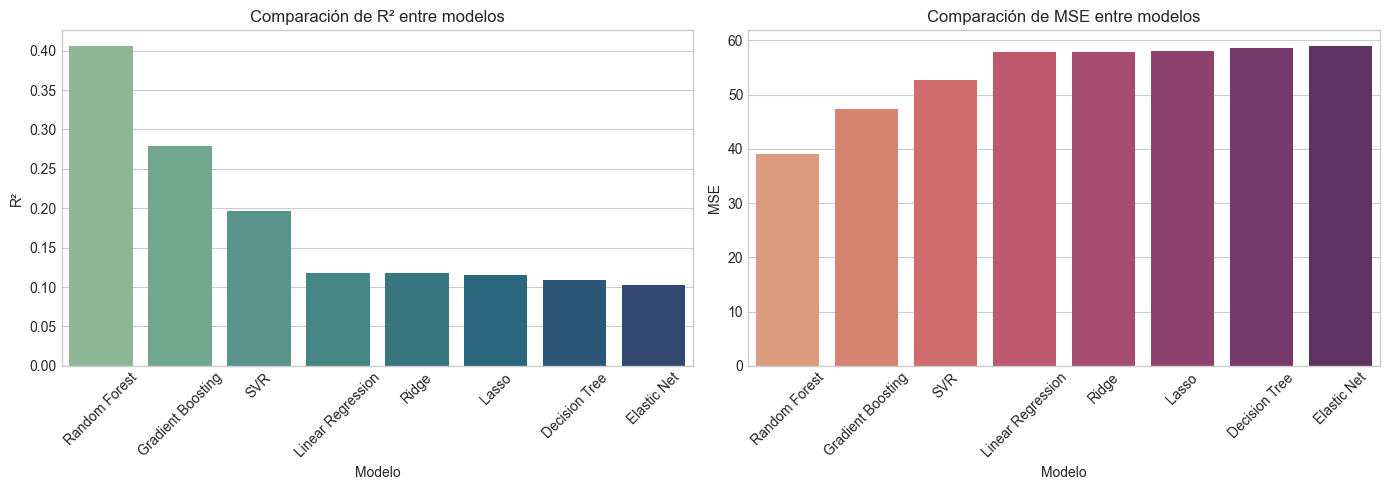

In [23]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="R2", ascending=False)

plt.figure(figsize=(14, 5))

# --- Gráfico R² ---
plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y="R2", data=results_df, palette="crest")
plt.xticks(rotation=45)
plt.title("Comparación de R² entre modelos")
plt.ylabel("R²")
plt.xlabel("Modelo")

# --- Gráfico MSE ---
plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y="MSE", data=results_df, palette="flare")
plt.xticks(rotation=45)
plt.title("Comparación de MSE entre modelos")
plt.ylabel("MSE")
plt.xlabel("Modelo")

plt.tight_layout()
plt.show()

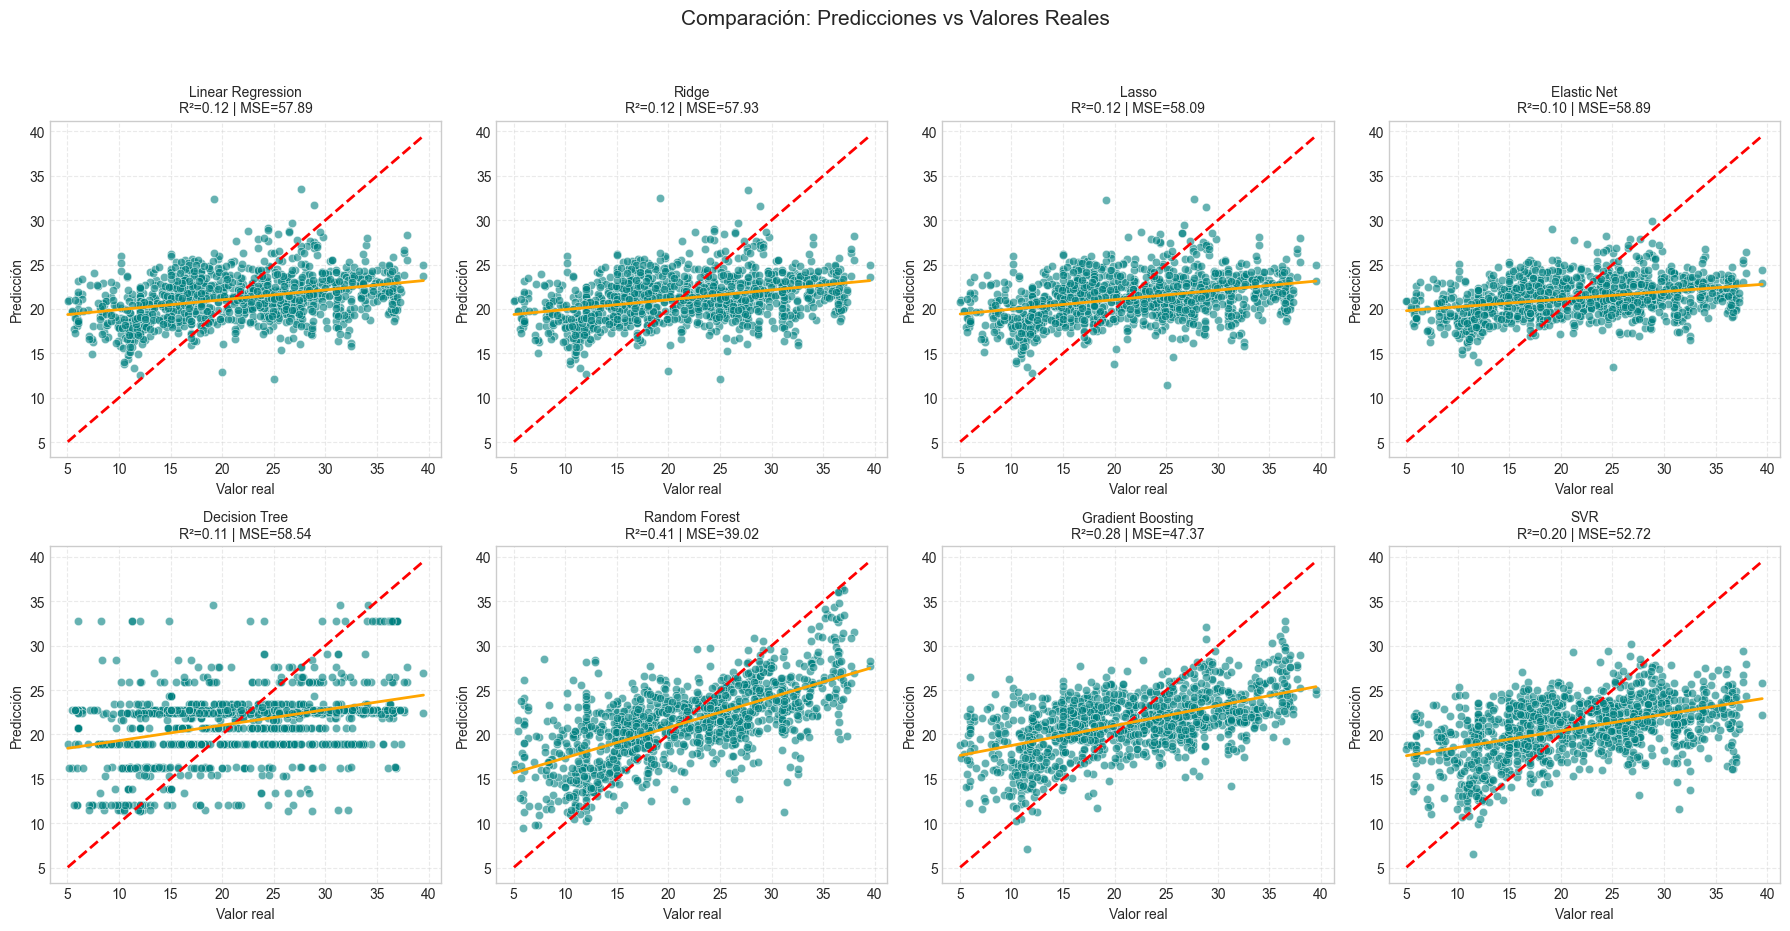

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error

# Crear figura
n_models = len(models)
fig, axes = plt.subplots(2, 4, figsize=(18, 9))  # Para 8 modelos
axes = axes.flatten()

for ax, (name, model) in zip(axes, models.items()):
    # Entrenar modelo
    model.fit(X_train, y_train)

    # Predecir
    y_pred = model.predict(X_test)

    # Calcular límites para línea perfecta
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())

    # Gráfico de dispersión
    sns.scatterplot(x=y_test, y=y_pred, ax=ax, color='teal', edgecolor='white', alpha=0.6)

    # Línea de predicción perfecta
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    # Línea de tendencia del modelo
    sns.regplot(x=y_test, y=y_pred, scatter=False, ax=ax, color='orange', line_kws={'lw':2}, ci=None)

    # Métricas
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    ax.set_title(f"{name}\nR²={r2:.2f} | MSE={mse:.2f}", fontsize=10)
    ax.set_xlabel("Valor real")
    ax.set_ylabel("Predicción")
    ax.grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Comparación: Predicciones vs Valores Reales", fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

C:\Users\Camila\AppData\Local\Temp\ipykernel_29264\3124020353.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Variable', data=feat_importances, palette='crest')


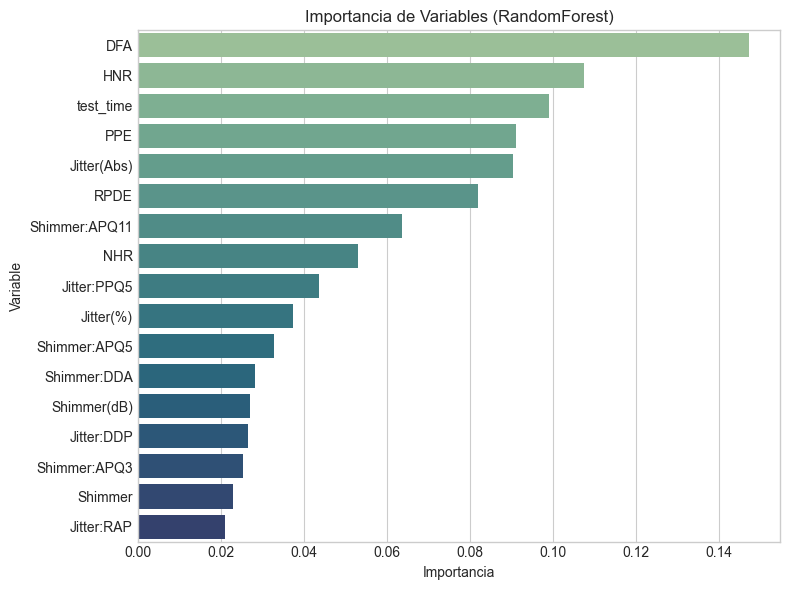

Variable  Importancia
15            DFA     0.147440
13            HNR     0.107560
0       test_time     0.099103
16            PPE     0.091205
2     Jitter(Abs)     0.090556
14           RPDE     0.081946
10  Shimmer:APQ11     0.063600
12            NHR     0.053064
4     Jitter:PPQ5     0.043720
1       Jitter(%)     0.037467
9    Shimmer:APQ5     0.032943
11    Shimmer:DDA     0.028184
7     Shimmer(dB)     0.027139
5      Jitter:DDP     0.026645
8    Shimmer:APQ3     0.025418
6         Shimmer     0.022868
3      Jitter:RAP     0.021141

In [25]:
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# Entrenamos RandomForest en TODOS LOS DATOS (para obtener importancias estables)
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_

feat_importances = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importancia', y='Variable', data=feat_importances, palette='crest')
plt.title("Importancia de Variables (RandomForest)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

feat_importances

In [26]:
# Convertir resultados en DataFrame
results_df = pd.DataFrame(results).T

# Mostrar ordenado por R2
results_df.sort_values(by="R2", ascending=False)

MSE        R2
Random Forest      39.038177  0.405382
Gradient Boosting  47.366981  0.278520
SVR                52.724769  0.196911
Linear Regression  57.888486  0.118259
Ridge              57.926970  0.117673
Lasso              58.088402  0.115214
Decision Tree      58.535680  0.108401
Elastic Net        58.889022  0.103019

In [27]:
best_model_name = results_df.sort_values(by="R2", ascending=False).index[0]
best_model_name

'Random Forest'

In [28]:
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

print(f"Modelo seleccionado: {best_model_name}")

Modelo seleccionado: Random Forest


In [29]:
import joblib
import os

# Crear la carpeta models si no existe
os.makedirs("models", exist_ok=True)

# Guardar modelo final
joblib.dump(best_model, "models/modelo_final.pkl")

# Guardar scaler
joblib.dump(scaler, "models/scaler.pkl")

print("Modelos guardados correctamente en la carpeta 'models/'")

Modelos guardados correctamente en la carpeta 'models/'


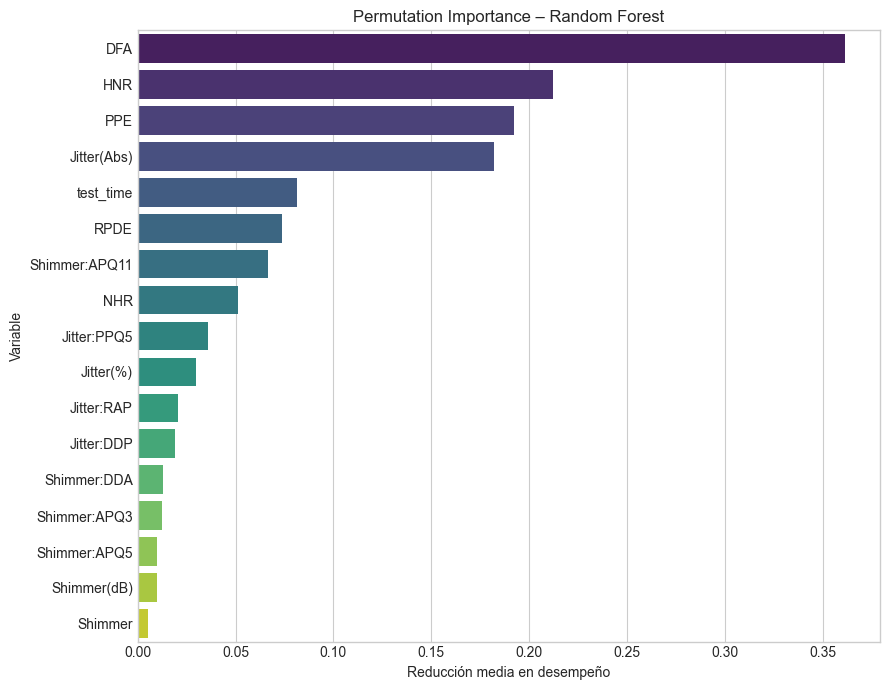

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Entrenar modelo Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Permutation Importance
result = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feat_perm = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": result.importances_mean,
    "STD": result.importances_std
}).sort_values(by="Importancia", ascending=False)

# ---- Gráfico ----
plt.figure(figsize=(9, 7))
sns.barplot(
    data=feat_perm,
    x="Importancia",
    y="Variable",
    hue="Variable",
    legend=False,
    palette="viridis"
)
plt.title("Permutation Importance – Random Forest")
plt.xlabel("Reducción media en desempeño")
plt.ylabel("Variable")

# Guardar imagen
plt.tight_layout()
plt.savefig("../app/images/permutation_importance.png", dpi=300)
plt.show()